In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

Read the housing data from a CSV file named 'housing_prices.csv'.
The delimiter for separating values is a comma, and the quote character is double quotes.

Read the population data from a CSV file named 'population_data.csv'.
The delimiter for separating values is a comma, and the quote character is double quotes.

In [2]:
housing_data = pd.read_csv("housing_prices.csv", delimiter=',', quotechar='"')
population_data = pd.read_csv("population_data.csv", delimiter=',', quotechar='"')

Filter the population data to get the row(s) where the "Country Name" matches the defined country_name.

In [3]:
country_name = "United Kingdom"
country_population = population_data[population_data["Country Name"] == country_name]

Select specific columns from the filtered 'country_population' DataFrame:

- "Country Name" and "Country Code" columns are kept.

- Adding columns for years 2013 to 2023 dynamically by iterating through the range of years.

In [4]:
country_population = country_population.loc[:, ["Country Name", "Country Code"] + [str(year) for year in range(2013, 2024)]]

Parse the XML file and store it as an ElementTree object.
Then get the root of the XML tree to begin traversing the XML structure.

Define a function to extract the value for the United Kingdom in 2013.
The function iterates through each 'record' in the XML to find the specific country and year.
- Extracts the 'Country or Area' and 'Year' values from the current record.
- Checks if the current record matches the United Kingdom and the year 2013.
- Extracts the value from the 'Value' field and returns it.
- Returns None if no matching record is found.

In [5]:
tree = ET.parse("land_of_countries.xml")
root = tree.getroot()

def extract_uk_value(root):
    for record in root.findall(".//record"):
        country = record.find(".//field[@name='Country or Area']").text
        year = record.find(".//field[@name='Year']").text
        
        if country == "United Kingdom" and year == "2013":
            value = record.find(".//field[@name='Value']").text
            return value
    return None

uk_value = extract_uk_value(root)

print(f"The value for the United Kingdom in 2013 is: {uk_value}")

The value for the United Kingdom in 2013 is: 241930


Reshape the 'country_population' DataFrame using melt:
- 'Country Name' and 'Country Code' are kept as identifier variables (id_vars).
- The 'Year' is used as a new column representing each year from 2013 to 2023.
- 'Population' values for each year are now stored in a column called 'Population'.

Ensure the 'Population' column is numeric: Any non-numeric values will be converted to NaN using 'errors='coerce''.

Ensure 'land_area' is numeric as well (assuming land_area is a separate variable): If 'uk_value' represents land_area, converte it to a numeric type.

Calculate the population density: Divide the population for each year by the land area to get population density.

In [6]:
uk_population = country_population.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Population")
uk_population["Population"] = pd.to_numeric(uk_population["Population"], errors='coerce')

land_area = pd.to_numeric(uk_value, errors='coerce')

uk_population["Population Density"] = uk_population["Population"] / land_area
uk_population["Population Density"].fillna(0, inplace=True)

print(uk_population)

      Country Name Country Code  Year  Population  Population Density
0   United Kingdom          GBR  2013  64128273.0          265.069537
1   United Kingdom          GBR  2014  64602298.0          267.028884
2   United Kingdom          GBR  2015  65116219.0          269.153139
3   United Kingdom          GBR  2016  65611593.0          271.200732
4   United Kingdom          GBR  2017  66058859.0          273.049473
5   United Kingdom          GBR  2018  66460344.0          274.708982
6   United Kingdom          GBR  2019  66836327.0          276.263080
7   United Kingdom          GBR  2020  67081234.0          277.275385
8   United Kingdom          GBR  2021  67026292.0          277.048287
9   United Kingdom          GBR  2022  67791000.0          280.209151
10  United Kingdom          GBR  2023  68350000.0          282.519737


Converte the 'Date' column in the 'housing_data' DataFrame to a datetime format, ensuring that the 'Date' column is properly recognized as a date type for time-based analysis.

In [7]:
housing_data['Date'] = pd.to_datetime(housing_data['Date'])

Filter the 'housing_data' DataFrame to select rows where:
- The month is August (month == 8).
- The day is the 1st (day == 1).
- The year is between 2013 and 2023 (inclusive).

Sort the 'filtered_data' DataFrame by the 'Date' column in ascending order, ensuring that the data is ordered chronologically.

In [8]:
filtered_data = housing_data[(housing_data['Date'].dt.month == 8) & (housing_data['Date'].dt.day == 1) & (housing_data['Date'].dt.year >= 2013) & (housing_data['Date'].dt.year <= 2023)]
filtered_data = filtered_data.sort_values(by='Date')

Extract the year from the 'Date' column and create a new 'Year' column in the 'housing_data' DataFrame.
The 'Date' column is first converted to datetime format, then the year is extracted.

Drop the 'Date' column from the 'housing_data' DataFrame, as the 'Year' column now contains the relevant information

In [9]:
housing_data = filtered_data[["Date", "Price (All)"]]
housing_data["Year"] = pd.to_datetime(housing_data["Date"]).dt.year
housing_data = housing_data.drop(columns=["Date"])

/var/folders/r9/hs7j8x6s2_qczl2vyt_y375w0000gn/T/ipykernel_5383/4278697785.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_data["Year"] = pd.to_datetime(housing_data["Date"]).dt.year


Ensure the 'Year' column in both DataFrames is of type int: Convert the 'Year' column to numeric, coercing errors to NaN and downcasting to integer.

Merge the two DataFrames (housing_data and uk_population) on the 'Year' column: The merge is performed with an inner join, keeping only rows with matching years in both DataFrames.

Group the merged DataFrame by 'Year' and calculating the mean for 'Price (All)' and 'Population Density': The groupby operation calculates the average values for both 'Price (All)' and 'Population Density' for each year.

In [10]:
housing_data["Year"] = pd.to_numeric(housing_data["Year"], errors="coerce", downcast="integer")
uk_population["Year"] = pd.to_numeric(uk_population["Year"], errors="coerce", downcast="integer")

merged_data = pd.merge(housing_data, uk_population, on="Year", how="inner")
merged_data_grouped = merged_data.groupby("Year")[["Price (All)", "Population Density"]].mean().reset_index()

print(merged_data_grouped)

    Year  Price (All)  Population Density
0   2013     170918.0          265.069537
1   2014     188810.0          267.028884
2   2015     195733.0          269.153139
3   2016     206346.0          271.200732
4   2017     211672.0          273.049473
5   2018     216103.0          274.708982
6   2019     216805.0          276.263080
7   2020     224337.0          277.275385
8   2021     247535.0          277.048287
9   2022     273135.0          280.209151
10  2023     260181.0          282.519737


Create a figure and axis for plotting: The 'figsize' sets the size of the plot, and 'ax1' will be the primary axis for housing prices.

Plot 'Price (All)' over 'Year' on the primary y-axis:
- 'sns.lineplot' is used to plot the line, with 'marker' set to 'o' and 'markersize' to 8 for better visibility.
- The line color is set to blue, with a solid line style and a linewidth of 2 for clarity.
- Set the labels for the primary y-axis ('Price (All)'): Label the x-axis as 'Year' and y-axis as 'Housing Price (in £)'.

Create a secondary y-axis for 'Population Density': The secondary y-axis is created using 'twinx()', which shares the same x-axis as 'ax1'.

Plot 'Population Density' over 'Year' on the secondary y-axis:
- The line for population density is plotted with a square marker ('s') and green color.
- The line style is dashed ('--') and linewidth is set to 2.
- Set the labels for the secondary y-axis ('Population Density'): Label the secondary y-axis as 'Population Density (per km²)'.

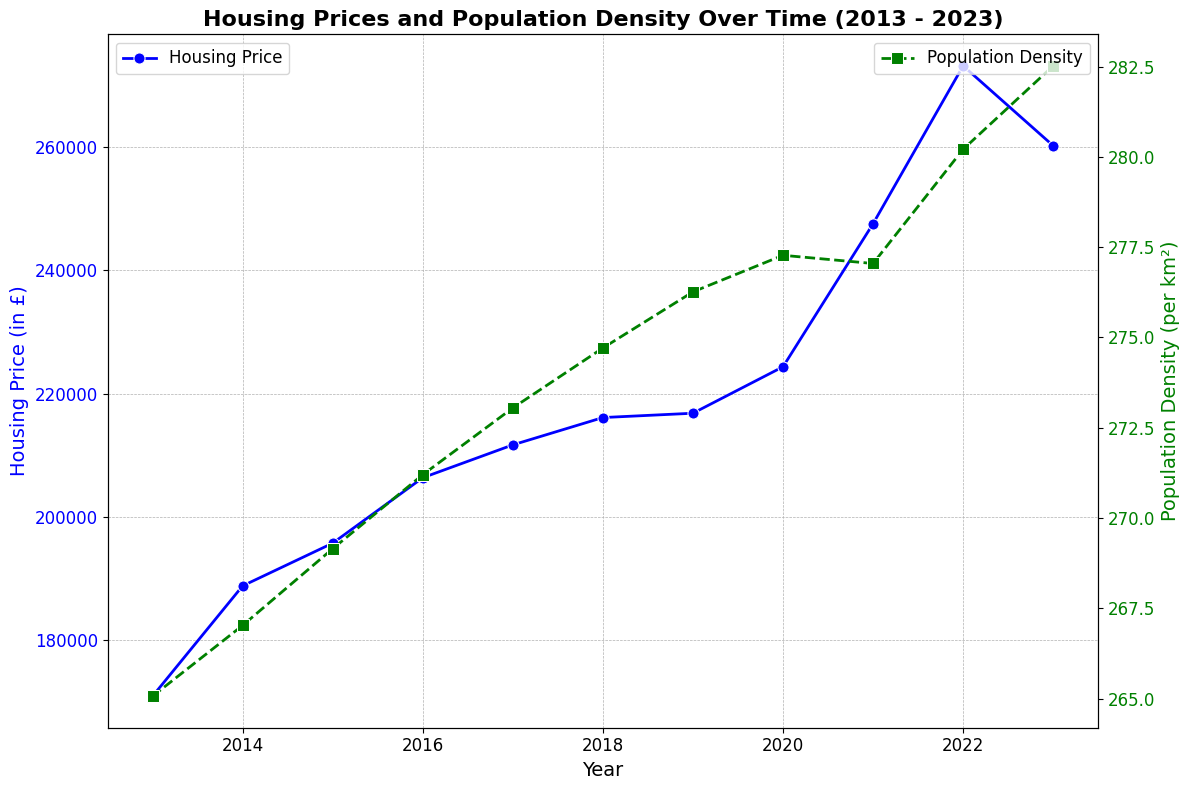

In [11]:
fig, ax1 = plt.subplots(figsize=(12, 8))

sns.lineplot(data=merged_data_grouped, x='Year', y='Price (All)', label='Housing Price', color='blue', marker='o', markersize=8, ax=ax1, linestyle='-', linewidth=2)
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('Housing Price (in £)', color='blue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='blue', labelsize=12)
ax1.tick_params(axis='x', labelsize=12)

ax2 = ax1.twinx()

sns.lineplot(data=merged_data_grouped, x='Year', y='Population Density', label='Population Density', color='green', marker='s', markersize=8, ax=ax2, linestyle='--', linewidth=2)
ax2.set_ylabel('Population Density (per km²)', color='green', fontsize=14)
ax2.tick_params(axis='y', labelcolor='green', labelsize=12)

plt.title('Housing Prices and Population Density Over Time (2013 - 2023)', fontsize=16, weight='bold')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.legend(loc='upper left', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)
fig.tight_layout()
plt.show()

Calculate the Pearson correlation coefficient between 'Price (All)' and 'Population Density'.

In [12]:
correlation = merged_data["Price (All)"].corr(merged_data["Population Density"])
print(f"Correlation between housing prices and population density: {correlation:.2f}")

Correlation between housing prices and population density: 0.94


Plot a graph showing the peak value of the housing prices.

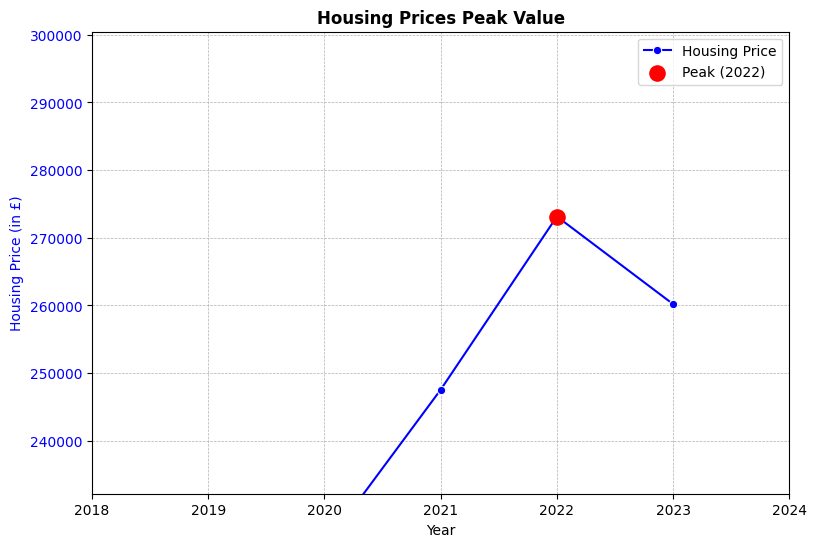

In [13]:
fig, ax = plt.subplots(figsize=(9, 6))
close_date = merged_data_grouped[(merged_data_grouped['Year'] >= 2018) & (merged_data_grouped['Year'] <= 2023)]

peak_year = 2022
peak_density = merged_data_grouped.loc[merged_data_grouped['Year'] == peak_year, 'Price (All)'].values[0]

sns.lineplot(data=close_date, x='Year', y='Price (All)', label='Housing Price', color='blue', marker='o', linestyle='-')
ax.scatter(peak_year, peak_density, color='red', s=120, label='Peak (2022)', marker='o', zorder=3)

ax.set_xlim(2018, 2024)
ax.set_ylim(peak_density * 0.85, peak_density * 1.10)
ax.set_xlabel('Year')
ax.set_ylabel('Housing Price (in £)', color='blue')
ax.tick_params(axis='y', labelcolor='blue')
ax.tick_params(axis='x')
plt.title('Housing Prices Peak Value', weight='bold')
ax.legend(loc='best')
ax.grid(True, linestyle='--', linewidth=0.5)
plt.show()

Plot a graph showing the peak value of the population density.

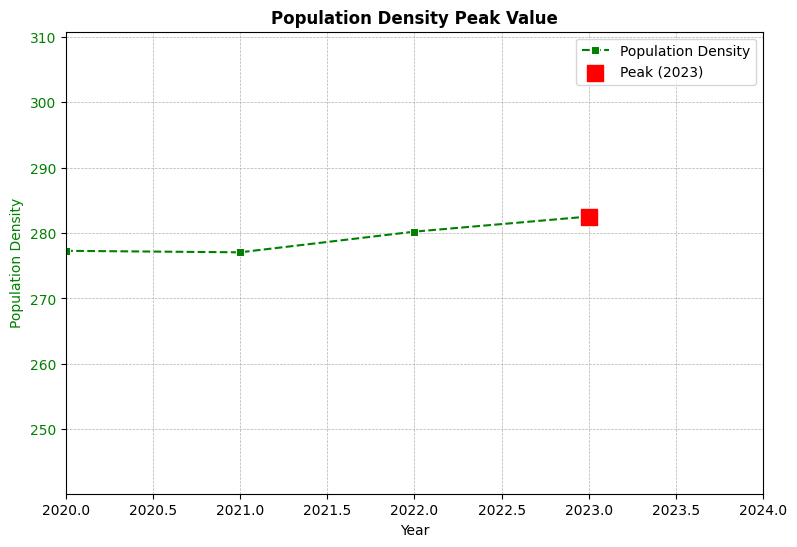

In [14]:
fig, ax = plt.subplots(figsize=(9, 6))
close_date = merged_data_grouped[(merged_data_grouped['Year'] >= 2018) & (merged_data_grouped['Year'] <= 2023)]

peak_year = 2023
peak_density = merged_data_grouped.loc[merged_data_grouped['Year'] == peak_year, 'Population Density'].values[0]

sns.lineplot(data=close_date, x='Year', y='Population Density', label='Population Density', color='green', marker='s', linestyle='--')
ax.scatter(peak_year, peak_density, color='red', s=120, label='Peak (2023)', marker='s', zorder=3)

ax.set_xlim(2020, 2024)
ax.set_ylim(peak_density * 0.85, peak_density * 1.10)
ax.set_xlabel('Year')
ax.set_ylabel('Population Density', color='green')
ax.tick_params(axis='y', labelcolor='green')
ax.tick_params(axis='x')
plt.title('Population Density Peak Value', weight='bold')
ax.legend(loc='best')
ax.grid(True, linestyle='--', linewidth=0.5)
plt.show()

Read the London population data from the uploaded CSV file.
Filter the data for the years 2013 to 2023.
Select only the 'Year' and 'Population' columns for the filtered data.
Ensure the 'Population' column is numeric in case there are any non-numeric values.

Read the London housing prices data.
Filter the data to get only May entries (period in format 'YYYY-05').
Select only the 'Period' (Year) and 'Average price All property types' columns.

Merge the population data with the housing price data based on 'Year', renaming the 'Average price All property types' column to 'price'.

Add a new column for population density.

In [15]:
london_population_data = pd.read_csv("london_population.csv", delimiter=',', quotechar='"')
london_population_filtered = london_population_data[london_population_data['Year'].between(2013, 2023)]
london_population = london_population_filtered[['Year', 'Population']]
london_population['Population'] = pd.to_numeric(london_population['Population'], errors='coerce')

london_prices_data = pd.read_csv("london_prices.csv", delimiter=',', quotechar='"')
london_prices_data['Period'] = pd.to_datetime(london_prices_data['Period'])
london_prices_may = london_prices_data[london_prices_data['Period'].dt.month == 5]
london_prices_may = london_prices_may[['Period', 'Average price All property types']]
london_prices_may['Year'] = london_prices_may['Period'].dt.year

merged_data_london = pd.merge(london_population, london_prices_may[['Year', 'Average price All property types']], on='Year', how='left')
merged_data_london.rename(columns={'Average price All property types': 'Average Price'}, inplace=True)

area_km2 = 1572     # The area of London in square kilometers
merged_data_london['Population Density'] = merged_data_london['Population'] / area_km2
merged_data_london.insert(1, 'City Name', 'London')

print(merged_data_london)

    Year City Name  Population  Average Price  Population Density
0   2013    London     8414000         322324         5352.417303
1   2014    London     8537000         382705         5430.661578
2   2015    London     8661000         415817         5509.541985
3   2016    London     8788000         467485         5590.330789
4   2017    London     8916000         480902         5671.755725
5   2018    London     9046000         478485         5754.452926
6   2019    London     9177000         463628         5837.786260
7   2020    London     9304000         473225         5918.575064
8   2021    London     9426000         488226         5996.183206
9   2022    London     9541000         517844         6069.338422
10  2023    London     9648000         518330         6137.404580


Load the CSV sile while skipping metadata rows and rename columns for easier processing.
- Filter for Pembrokeshire's row.
- Drop unnecessary location columns.
- Reshape data from wide to long format.
- Clean up the Population column.
- Ensure Year column is of type int.
- Filter for years 2013-2023.

Load the CSV file for the prices data.
- Process prices data to get yearly average prices
- Ensure Year column is of type int.

Merge population and prices data, add a Population Density column.

Use a quadratic trend for better prediction and predict 2023 price.

Add 2023 data row and City Name column.
Ensure data is sorted by Year in ascending order.

In [16]:
population_data = pd.read_csv("pembrokeshire_population.csv", skiprows=6, header=0)
population_data.columns = population_data.columns.str.replace('Mid-year ', '').str.strip()

pembrokeshire_data = population_data[population_data.iloc[:, 3] == "Pembrokeshire "]
pembrokeshire_data = pembrokeshire_data.iloc[:, 4:]
pembrokeshire_data = pembrokeshire_data.melt(var_name="Year", value_name="Population")
pembrokeshire_data["Population"] = pembrokeshire_data["Population"].astype(int)
pembrokeshire_data["Year"] = pembrokeshire_data["Year"].astype(int)
pembrokeshire_data = pembrokeshire_data[(pembrokeshire_data["Year"] >= 2013) & (pembrokeshire_data["Year"] <= 2023)]

pembrokeshire_prices_data = pd.read_csv("pembrokeshire_prices.csv")
pembrokeshire_prices_data["Period"] = pd.to_datetime(pembrokeshire_prices_data["Period"])

prices_yearly = pembrokeshire_prices_data.groupby(pembrokeshire_prices_data["Period"].dt.year)["Average price All property types"].mean().reset_index()
prices_yearly.columns = ["Year", "Average Price"]
prices_yearly["Year"] = prices_yearly["Year"].astype(int)

pembrokeshire_merged_data = pd.merge(pembrokeshire_data, prices_yearly, on="Year", how="inner")

area = 1618     # Area of Pembrokeshire in square kilometers
pembrokeshire_merged_data["Population Density"] = (pembrokeshire_merged_data["Population"] / area).round(2)

price_trend = np.polyfit(pembrokeshire_merged_data["Year"], pembrokeshire_merged_data["Average Price"], 2)
price_predictor = np.poly1d(price_trend)
predicted_price_2023 = price_predictor(2023)

population_2023 = pembrokeshire_data[pembrokeshire_data["Year"] == 2023]["Population"].values[0]
new_row = {
    "Year": 2023,
    "Population": population_2023,
    "Average Price": round(predicted_price_2023, 2),
    "Population Density": round(population_2023 / area, 2),
}
pembrokeshire_merged_data = pd.concat([pembrokeshire_merged_data, pd.DataFrame([new_row])], ignore_index=True)
pembrokeshire_merged_data.insert(1, "City Name", "Pembrokeshire")
pembrokeshire_merged_data = pembrokeshire_merged_data.sort_values(by="Year", ascending=True).reset_index(drop=True)

print(pembrokeshire_merged_data.to_string(index=False))

 Year     City Name  Population  Average Price  Population Density
 2013 Pembrokeshire      122302  151667.416667               75.59
 2014 Pembrokeshire      122148  151118.166667               75.49
 2015 Pembrokeshire      121721  155414.166667               75.23
 2016 Pembrokeshire      121438  158024.333333               75.05
 2017 Pembrokeshire      121382  163366.916667               75.02
 2018 Pembrokeshire      121194  166542.166667               74.90
 2019 Pembrokeshire      121432  175738.500000               75.05
 2020 Pembrokeshire      122572  182373.000000               75.76
 2021 Pembrokeshire      123633  202036.416667               76.41
 2022 Pembrokeshire      124365  231559.545455               76.86
 2023 Pembrokeshire      125006  244916.270000               77.26


Create a figure and axis for London.
Plot London housing prices on the left y-axis.
Create a second y-axis for Population Density.

Create a figure and axis for Pembrokeshire.
Plot Pembrokeshire housing prices on the left y-axis.
Create a second y-axis for Population Density.

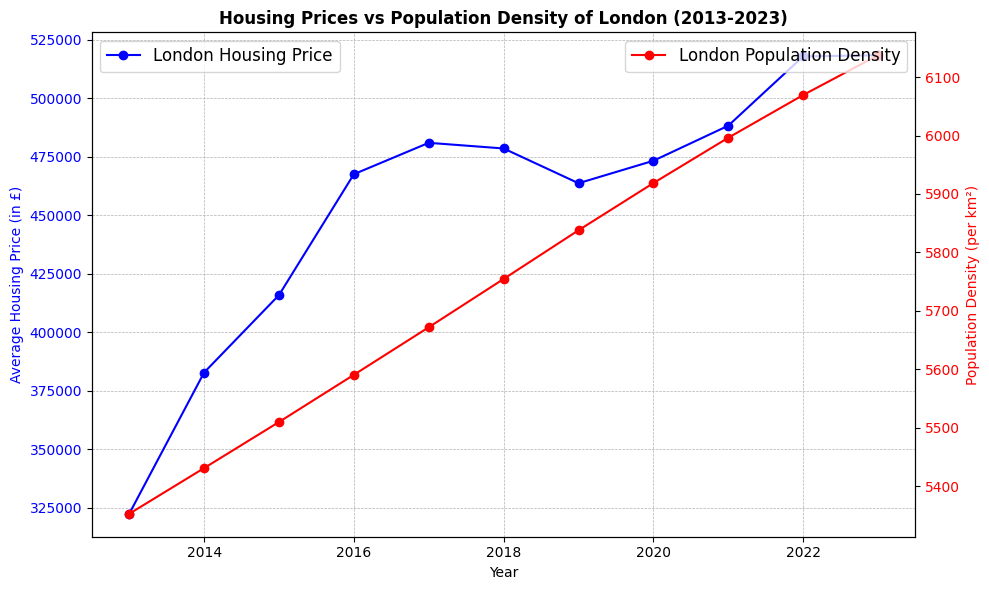

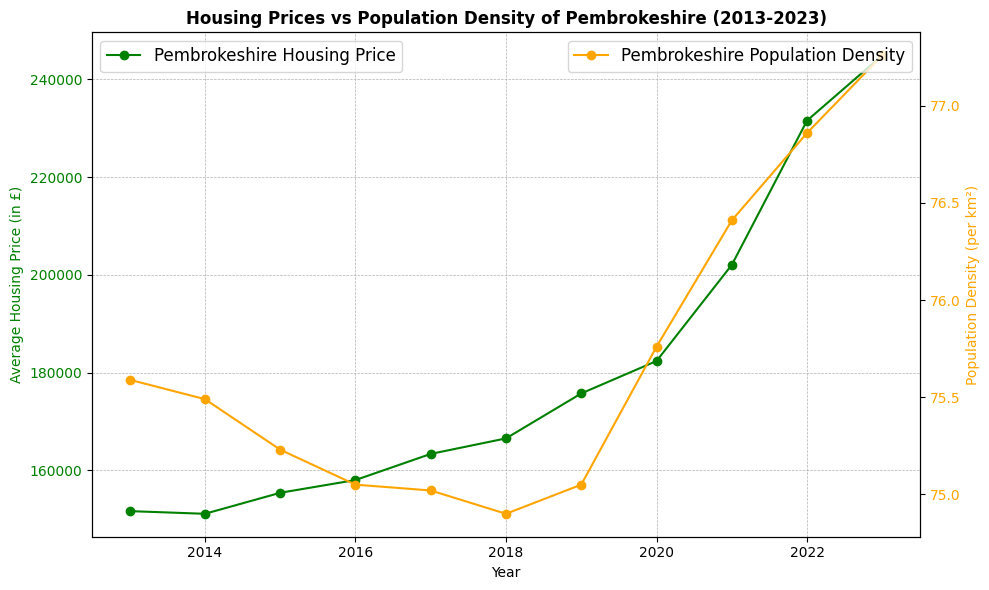

In [17]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(merged_data_london['Year'], merged_data_london['Average Price'], color='blue', label="London Housing Price", marker='o')
ax1.set_xlabel("Year")
ax1.set_ylabel("Average Housing Price (in £)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(merged_data_london['Year'], merged_data_london['Population Density'], color='red', label="London Population Density", marker='o')
ax2.set_ylabel("Population Density (per km²)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Housing Prices vs Population Density of London (2013-2023)', weight='bold')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.legend(loc='upper left', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)
fig.tight_layout()
plt.show()

fig, ax3 = plt.subplots(figsize=(10, 6))

ax3.plot(pembrokeshire_merged_data['Year'], pembrokeshire_merged_data['Average Price'], color='green', label="Pembrokeshire Housing Price", marker='o')
ax3.set_xlabel("Year")
ax3.set_ylabel("Average Housing Price (in £)", color='green')
ax3.tick_params(axis='y', labelcolor='green')

ax4 = ax3.twinx()
ax4.plot(pembrokeshire_merged_data['Year'], pembrokeshire_merged_data['Population Density'], color='orange', label="Pembrokeshire Population Density", marker='o')
ax4.set_ylabel("Population Density (per km²)", color='orange')
ax4.tick_params(axis='y', labelcolor='orange')

plt.title('Housing Prices vs Population Density of Pembrokeshire (2013-2023)', weight='bold')
ax3.grid(True, which='both', linestyle='--', linewidth=0.5)
ax3.legend(loc='upper left', fontsize=12)
ax4.legend(loc='upper right', fontsize=12)
fig.tight_layout()
plt.show()

Load the CSV file.
Define the name of the country to filter the population data.
Filter the population data to get the row(s) where the "Country Name" matches the defined country_name.

Calculate the average yearly population increase.

In [18]:
population_data = pd.read_csv("population_data.csv", delimiter=',', quotechar='"')
country_name = "United Kingdom"
uk_population = population_data[population_data["Country Name"] == country_name]

years = [str(year) for year in range(2013, 2024)]
uk_population = uk_population.loc[:, ["Country Name"] + years]

uk_population_melted = uk_population.melt(
    id_vars=["Country Name"],
    var_name="Year",
    value_name="Population"
)

uk_population_melted["Year"] = uk_population_melted["Year"].astype(int)
uk_population_melted = uk_population_melted.sort_values("Year")
uk_population_melted["Population Increase"] = uk_population_melted["Population"].diff().fillna(0)
average_population_increase = uk_population_melted["Population Increase"].mean()

print(uk_population_melted)
print()
print(f"Average yearly population increase (2013-2023): {average_population_increase:.2f}")

      Country Name  Year  Population  Population Increase
0   United Kingdom  2013  64128273.0                  0.0
1   United Kingdom  2014  64602298.0             474025.0
2   United Kingdom  2015  65116219.0             513921.0
3   United Kingdom  2016  65611593.0             495374.0
4   United Kingdom  2017  66058859.0             447266.0
5   United Kingdom  2018  66460344.0             401485.0
6   United Kingdom  2019  66836327.0             375983.0
7   United Kingdom  2020  67081234.0             244907.0
8   United Kingdom  2021  67026292.0             -54942.0
9   United Kingdom  2022  67791000.0             764708.0
10  United Kingdom  2023  68350000.0             559000.0

Average yearly population increase (2013-2023): 383793.36


Calculate the average yearly housing prices increase.

In [19]:
housing_data = housing_data.sort_values("Year")
housing_data["Price Increase"] = housing_data["Price (All)"].diff().fillna(0)
average_price_increase = housing_data["Price Increase"].mean()

print(housing_data)
print()
print(f"Average yearly housing prices increase (2013-2023) in pounds: {average_price_increase:.2f}")

    Price (All)  Year  Price Increase
44       170918  2013             0.0
40       188810  2014         17892.0
36       195733  2015          6923.0
32       206346  2016         10613.0
28       211672  2017          5326.0
24       216103  2018          4431.0
20       216805  2019           702.0
16       224337  2020          7532.0
12       247535  2021         23198.0
8        273135  2022         25600.0
4        260181  2023        -12954.0

Average yearly housing prices increase (2013-2023) in pounds: 8114.82


Calculate the price change per unit of population increase.

In [20]:
price_change_per_population_unit = average_price_increase / average_population_increase

print(f"Price change per unit of population increase in pounds: {price_change_per_population_unit:.4f}")
print(f"Price change for every 100000 population increase in pounds: {(price_change_per_population_unit*100000):.4f}")

Price change per unit of population increase in pounds: 0.0211
Price change for every 100000 population increase in pounds: 2114.3717
